Import libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt
import collections
import optuna
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load the dataset and split into Test, Validation and Train

In [15]:
import tensorflow_datasets as tfds

def load_imdb_data():
    imdb, _ = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
    return imdb['train'], imdb['test']

train_data, test_data = load_imdb_data()

In [16]:
def split_train_validation(train_data, validation_split=0.2):
    train_list = list(train_data.skip(int(validation_split * len(list(train_data)))).as_numpy_iterator())
    validation_list = list(train_data.take(int(validation_split * len(list(train_data)))).as_numpy_iterator())

    train_labels = [label for _, label in train_list]
    validation_labels = [label for _, label in validation_list]

    print(f"Training set size: {len(train_list)}")
    print(f"Validation set size: {len(validation_list)}")

    return train_list, validation_list, train_labels, validation_labels

train_list, validation_list, train_labels, validation_labels = split_train_validation(train_data)

test_list = list(test_data.as_numpy_iterator())
test_labels = [label for _, label in test_list]

print(f"Test set size: {len(test_list)}")

Training set size: 20000
Validation set size: 5000
Test set size: 25000


EDA

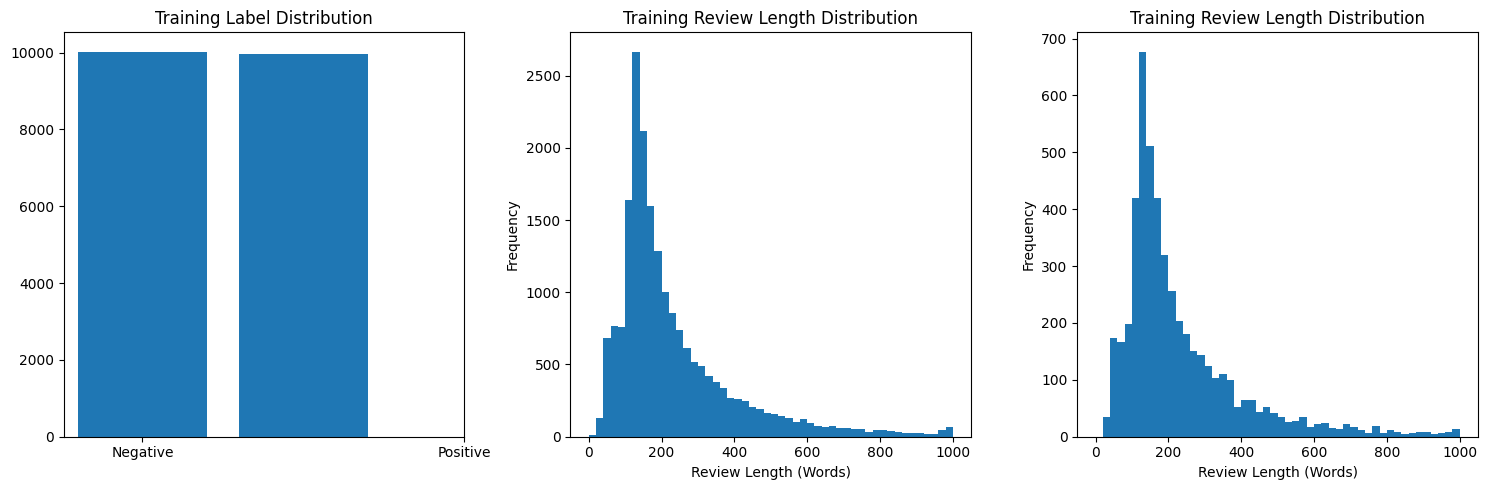

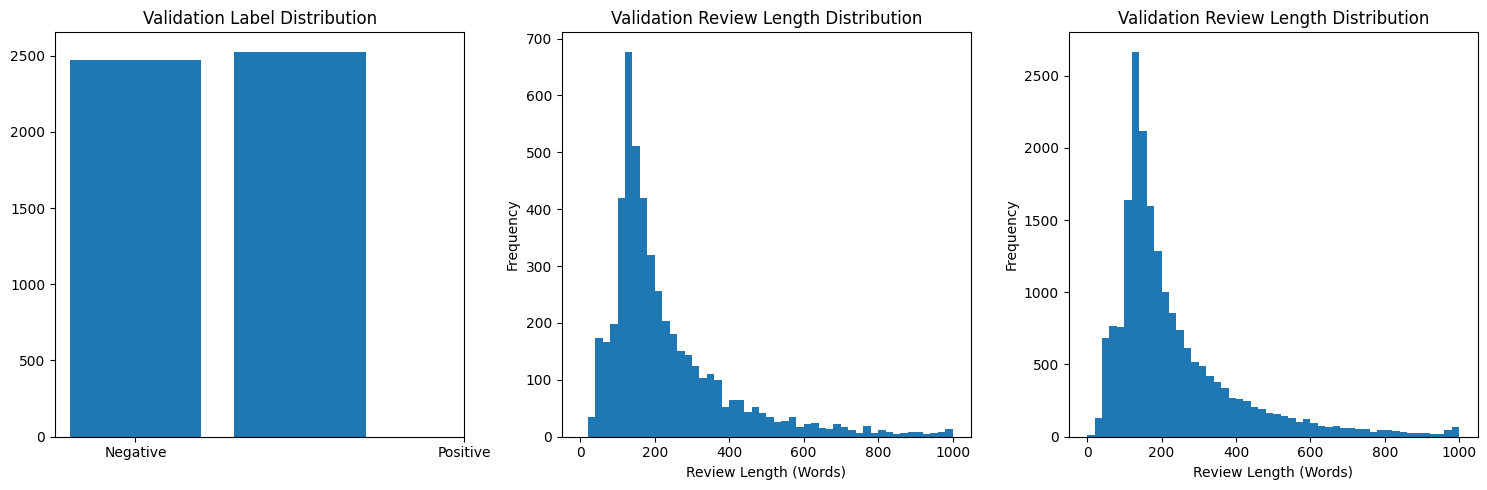

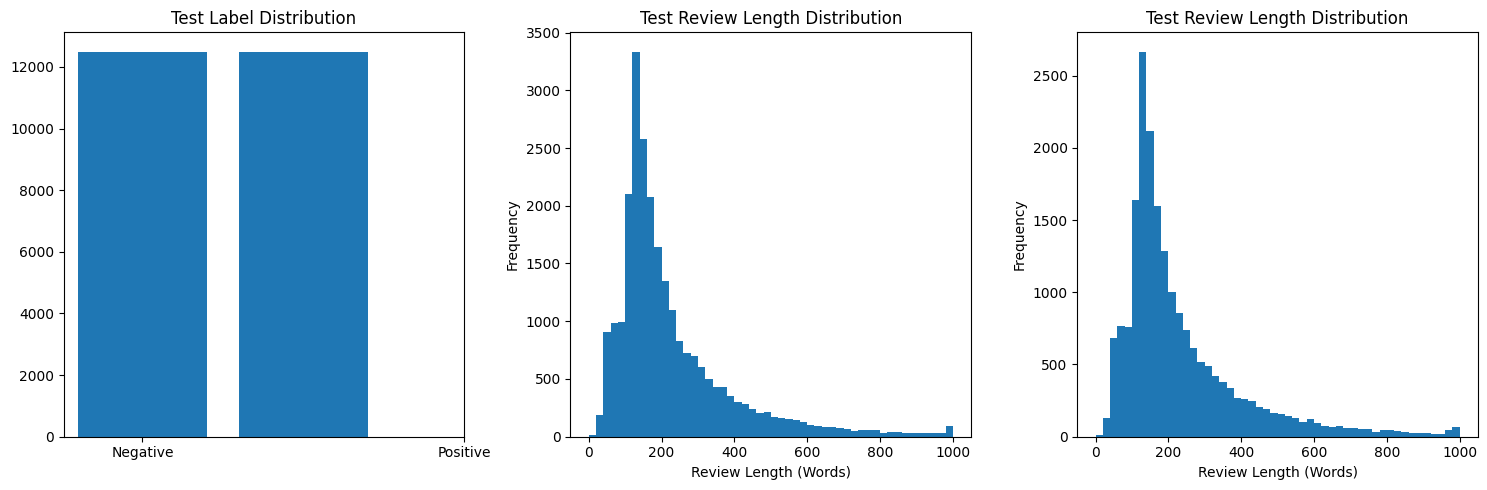


Average Training Review Length: 233.90 words
Average Validation Review Length: 233.35 words
Average Test Review Length: 228.53 words


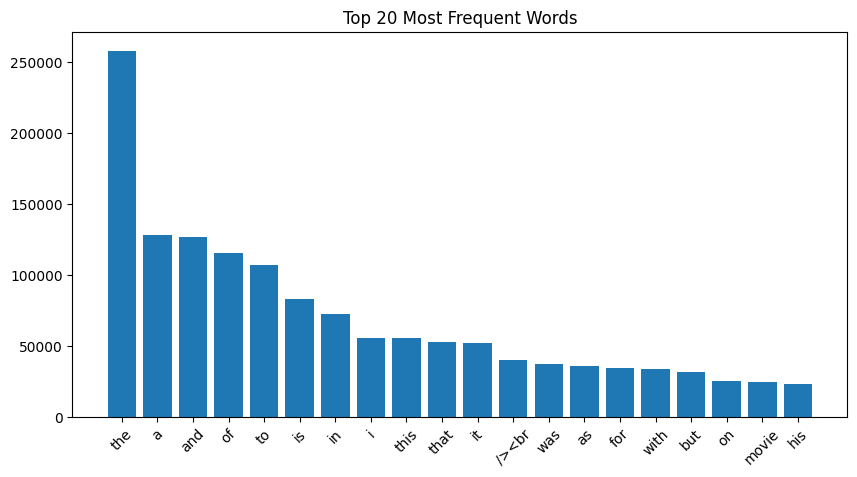

Average Word Length: 4.67
Unique Word Count: 219700
Review Length Standard Deviation: 173.50
Html tag count: 81191
Special character count: 1066364


In [17]:
def plot_distributions(labels_list, lengths_list, title_prefix):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(labels_list[0], bins=2, rwidth=0.8, align='left')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title(f'{title_prefix} Label Distribution')

    plt.subplot(1, 3, 2)
    plt.hist(lengths_list[0], bins=50, range=(0, 1000))
    plt.title(f'{title_prefix} Review Length Distribution')
    plt.xlabel('Review Length (Words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(lengths_list[1], bins=50, range=(0, 1000))
    plt.title(f'{title_prefix} Review Length Distribution')
    plt.xlabel('Review Length (Words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def analyze_words(text_list):
    all_words = []
    for text, _ in text_list:
        all_words.extend(text.decode('utf-8').lower().split())

    word_counts = collections.Counter(all_words)
    top_words = word_counts.most_common(20)

    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title('Top 20 Most Frequent Words')
    plt.show()

    word_lengths = [len(word) for word in all_words]
    print(f"Average Word Length: {np.mean(word_lengths):.2f}")
    print(f"Unique Word Count: {len(set(all_words))}")

def analyze_special_chars(text_list):
    html_tag_regex = re.compile(r'<[^>]+>')
    special_char_regex = re.compile(r'[^a-zA-Z0-9\s]')

    html_tag_count = 0
    special_char_count = 0

    for text, _ in text_list:
        decoded_text = text.decode('utf-8')
        html_tag_count += len(html_tag_regex.findall(decoded_text))
        special_char_count += len(special_char_regex.findall(decoded_text))

    print(f"Html tag count: {html_tag_count}")
    print(f"Special character count: {special_char_count}")

# Calculate lengths
train_lengths = [len(text.decode('utf-8').split()) for text, _ in train_list]
validation_lengths = [len(text.decode('utf-8').split()) for text, _ in validation_list]
test_lengths = [len(text.decode('utf-8').split()) for text, _ in test_list]

# Plot Distributions
plot_distributions([train_labels, validation_labels, test_labels], [train_lengths, validation_lengths, test_lengths], 'Training')
plot_distributions([validation_labels, train_labels, test_labels], [validation_lengths, train_lengths, test_lengths], 'Validation')
plot_distributions([test_labels, train_labels, validation_labels], [test_lengths, train_lengths, validation_lengths], 'Test')

# Average Review Length
print(f"\nAverage Training Review Length: {np.mean(train_lengths):.2f} words")
print(f"Average Validation Review Length: {np.mean(validation_lengths):.2f} words")
print(f"Average Test Review Length: {np.mean(test_lengths):.2f} words")

# Word Analysis
analyze_words(train_list)

# Review Length Variability
print(f"Review Length Standard Deviation: {np.std(train_lengths):.2f}")

# Special Character Analysis
analyze_special_chars(train_list)

Text Preprocessing

In [18]:
def remove_html_tags(text):
    """Removes HTML tags from a string."""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def decode_clean_text(data_list):
    """Decodes byte strings and removes HTML tags from text data."""
    sentences = [remove_html_tags(text.decode('utf-8')) for text, _ in data_list]
    return sentences

def tokenize_pad_sequences(train_sentences, validation_sentences, test_sentences, num_words=20000, max_length=200):
    """Tokenizes and pads text sequences."""
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_sentences)

    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)

    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
    validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

    return train_padded, validation_padded, test_padded

def create_tensors_dataloaders(train_padded, validation_padded, test_padded, train_list, validation_list, test_list, batch_size=64):
    """Converts padded sequences and labels to PyTorch tensors and DataLoaders."""
    train_labels_np = np.array([label for _, label in train_list])
    validation_labels_np = np.array([label for _, label in validation_list])
    test_labels_np = np.array([label for _, label in test_list])

    train_data = torch.tensor(train_padded, dtype=torch.long)
    train_labels_tensor = torch.tensor(train_labels_np, dtype=torch.float32).view(-1, 1)
    validation_data = torch.tensor(validation_padded, dtype=torch.long)
    validation_labels_tensor = torch.tensor(validation_labels_np, dtype=torch.float32).view(-1, 1)
    test_data = torch.tensor(test_padded, dtype=torch.long)
    test_labels_tensor = torch.tensor(test_labels_np, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(train_data, train_labels_tensor)
    validation_dataset = TensorDataset(validation_data, validation_labels_tensor)
    test_dataset = TensorDataset(test_data, test_labels_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, validation_loader, test_loader

def process_text(train_list, validation_list, test_list, num_words=20000, max_length=200, batch_size=64):
    """Executes the text processing pipeline."""
    train_sentences = decode_clean_text(train_list)
    validation_sentences = decode_clean_text(validation_list)
    test_sentences = decode_clean_text(test_list)

    train_padded, validation_padded, test_padded = tokenize_pad_sequences(train_sentences, validation_sentences, test_sentences, num_words, max_length)

    train_loader, validation_loader, test_loader = create_tensors_dataloaders(train_padded, validation_padded, test_padded, train_list, validation_list, test_list, batch_size)

    return train_loader, validation_loader, test_loader

train_loader, validation_loader, test_loader = process_text(train_list, validation_list, test_list)

Model definition

In [95]:
def create_rnn_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, device):
    """Creates and returns an RNN model with normalization."""
    class RNN(nn.Module):
        def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate):
            super(RNN, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.embedding_norm = nn.LayerNorm(embedding_dim)
            self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
            self.lstm_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
            self.fc_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
            self.sigmoid = nn.Sigmoid()

        def forward(self, text):
            embedded = self.embedding(text)
            embedded_norm = self.embedding_norm(embedded)
            output, (hidden, cell) = self.lstm(embedded_norm)
            if bidirectional:
                hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
            else:
                hidden = hidden[-1, :, :]
            hidden_norm = self.lstm_norm(hidden)
            hidden_drop = self.dropout(hidden_norm)
            hidden_fc_norm = self.fc_norm(hidden_drop)
            out = self.fc(hidden_fc_norm)
            return self.sigmoid(out)
    return RNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate).to(device)

# Model Parameters
vocab_size = 20000
embedding_dim = 64
hidden_dim = 32
output_dim = 1
num_layers = 3
bidirectional = True
dropout_rate = 0.4
weight_decay = 0.0001

# Create the model
model = create_rnn_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, device)

Training The model

Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6937          0.5244          0.6830          0.5794         
2          0.6006          0.6836          0.5842          0.6968         
3          0.5530          0.7206          0.5809          0.7402         
4          0.4404          0.8060          0.4859          0.7878         
5          0.3645          0.8458          0.4334          0.8212         
6          0.3264          0.8660          0.4406          0.8318         
7          0.2980          0.8796          0.4371          0.8376         
8          0.2583          0.8994          0.5022          0.8364         
9          0.2293          0.9141          0.4458          0.8416         
10         0.2043          0.9236          0.5390          0.8304         
Early stopping triggered!


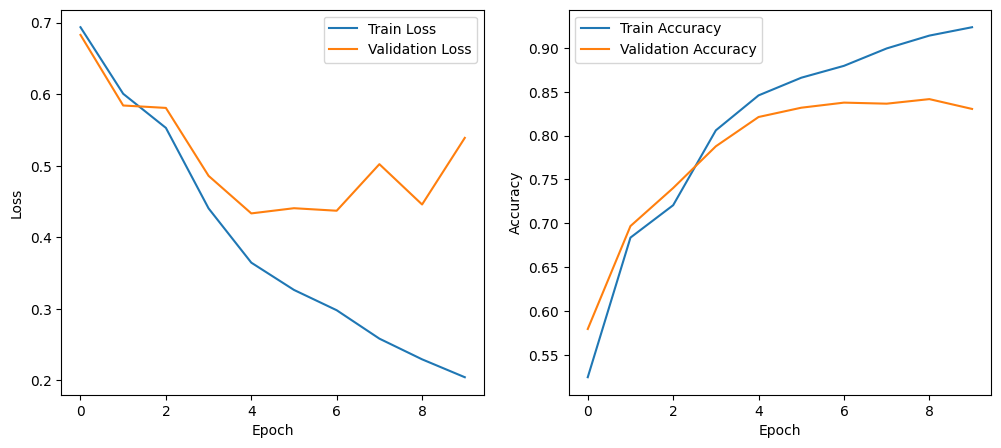

In [96]:
def train_validate(model, train_loader, validation_loader, epochs=10, patience=5):
    """Trains and validates the model with early stopping."""
    torch.cuda.empty_cache()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    counter = 0

    print("{:<10} {:<15} {:<15} {:<15} {:<15}".format("Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc"))
    print("-" * 65)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_text, batch_labels in train_loader:
            batch_text = batch_text.to(model.embedding.weight.device)
            batch_labels = batch_labels.to(model.embedding.weight.device)
            optimizer.zero_grad()
            predictions = model(batch_text)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted_train = torch.round(predictions)
            correct_train += (predicted_train == batch_labels).sum().item()
            total_train += batch_labels.size(0)

        train_accuracy = correct_train / total_train
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_text, batch_labels in validation_loader:
                batch_text = batch_text.to(model.embedding.weight.device)
                batch_labels = batch_labels.to(model.embedding.weight.device)
                predictions = model(batch_text)
                loss = criterion(predictions, batch_labels)
                total_val_loss += loss.item()
                predicted_val = torch.round(predictions)
                correct_val += (predicted_val == batch_labels).sum().item()
                total_val += batch_labels.size(0)

        val_accuracy = correct_val / total_val
        avg_val_loss = total_val_loss / len(validation_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print("{:<10} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(epoch + 1, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy))

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Train and validate the model
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, validation_loader)

# Plot the results
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

Test Execution

In [76]:
criterion = nn.BCELoss()

model.eval()
test_loss = 0
correct_test = 0
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_text)
        test_loss += criterion(predictions, batch_labels).item()
        predicted_test = torch.round(predictions)
        correct_test += (predicted_test == batch_labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4774, Test Accuracy: 0.8034


In [88]:
def objective(trial):
    # Hyperparameters to tune
    embedding_dim = trial.suggest_int('embedding_dim', 8, 32)
    hidden_dim = trial.suggest_int('hidden_dim', 8, 32)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-1, log=True)

    # Model Parameters
    vocab_size = 20000
    output_dim = 1

    # Instantiate the model
    model = create_rnn_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

    # Training Loop
    epochs = 20 
    for epoch in range(epochs):
        model.train()
        for batch_text, batch_labels in train_loader:
            batch_text = batch_text.to(model.embedding.weight.device)
            batch_labels = batch_labels.to(model.embedding.weight.device)
            optimizer.zero_grad()
            predictions = model(batch_text)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_text, batch_labels in validation_loader:
            batch_text = batch_text.to(model.embedding.weight.device) 
            batch_labels = batch_labels.to(model.embedding.weight.device)
            predictions = model(batch_text)
            predicted = torch.round(predictions)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy

def print_trial_results(study):
    print("{:<6} {:<10} {:<15} {:<15} {:<10} {:<15} {:<15} {:<15}".format(
        "Trial", "Accuracy", "Embedding", "Hidden", "Layers", "Bidirect", "Dropout", "Weight Decay"
    ))
    print("-" * 115)
    for trial in study.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            print("{:<6} {:<10.4f} {:<15} {:<15} {:<10} {:<15} {:<15.6f} {:<15.6e}".format(
                trial.number,
                trial.value,
                trial.params['embedding_dim'],
                trial.params['hidden_dim'],
                trial.params['num_layers'],
                trial.params['bidirectional'],
                trial.params['dropout_rate'],
                trial.params['weight_decay']
            ))

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=False)

# Print table
print_trial_results(study)

# Best hyperparameters
best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

[I 2025-04-11 15:25:16,754] A new study created in memory with name: no-name-eee85936-8bcc-4d05-b2b6-9b97b6129d8c
[I 2025-04-11 15:25:58,343] Trial 0 finished with value: 0.7522 and parameters: {'embedding_dim': 19, 'hidden_dim': 16, 'num_layers': 3, 'bidirectional': False, 'dropout_rate': 0.43716053456386905, 'weight_decay': 4.789805223552268e-06}. Best is trial 0 with value: 0.7522.
[I 2025-04-11 15:26:30,355] Trial 1 finished with value: 0.6246 and parameters: {'embedding_dim': 20, 'hidden_dim': 9, 'num_layers': 2, 'bidirectional': False, 'dropout_rate': 0.10604707670152874, 'weight_decay': 0.0003593936791309365}. Best is trial 0 with value: 0.7522.
[I 2025-04-11 15:27:31,680] Trial 2 finished with value: 0.5052 and parameters: {'embedding_dim': 8, 'hidden_dim': 25, 'num_layers': 4, 'bidirectional': True, 'dropout_rate': 0.4680719058265319, 'weight_decay': 0.00017295914583516722}. Best is trial 0 with value: 0.7522.
[I 2025-04-11 15:28:10,403] Trial 3 finished with value: 0.5976 and

Trial  Accuracy   Embedding       Hidden          Layers     Bidirect        Dropout         Weight Decay   
-------------------------------------------------------------------------------------------------------------------
0      0.7522     19              16              3          0               0.437161        4.789805e-06   
1      0.6246     20              9               2          0               0.106047        3.593937e-04   
2      0.5052     8               25              4          1               0.468072        1.729591e-04   
3      0.5976     11              17              4          0               0.266485        8.919809e-06   
4      0.8198     27              32              3          1               0.218202        8.318801e-04   
5      0.4948     9               27              4          0               0.478489        1.478558e-06   
6      0.5548     20              13              2          0               0.294135        2.818516e-04   
7      0.494

In [97]:
# Best Parameters
vocab_size = 20000
embedding_dim = 32
hidden_dim = 8
output_dim = 1
num_layers = 3
bidirectional = True
dropout_rate = 0.10975816347949469
weight_decay = 5.093935503809587e-05

criterion = nn.BCELoss()

model.eval()
test_loss = 0
correct_test = 0
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_text)
        test_loss += criterion(predictions, batch_labels).item()
        predicted_test = torch.round(predictions)
        correct_test += (predicted_test == batch_labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")



Test Loss: 0.6169, Test Accuracy: 0.8051
